In [131]:
import numpy as np
import matplotlib.pyplot as plt

In [242]:
def divideArrayIntoBatches (array, num_divisions) -> list:
    """
    Divides a 2D array into 16 batches.
    
    Args:
        array: a 2D numpy array.
        num_divisions: The number of divisions to use.

    Returns:
    A list of 16 2D numpy arrays, each of which is a batch of the input array.
    """

    if len (array.shape) != 2:
        raise ValueError ("Input array must be 2D")

    num_rows, num_cols = array.shape

    if num_rows == 0 or num_cols == 0:
        return []
    
    batch_size_rows = (num_rows) // num_divisions
    batch_size_cols = (num_cols) // num_divisions

    batches = []
    for i in range (num_divisions):
        for j in range (num_divisions):
            batch = array [i * batch_size_rows: (i + 1) * batch_size_rows,
                           j * batch_size_cols: (j + 1) * batch_size_cols]
            batches.append (batch)

    return batches

def exportToExcel (array, str = 'diff.xlsx'):
    import pandas as pd

    temp = pd.DataFrame (array)
    temp.to_excel (str);


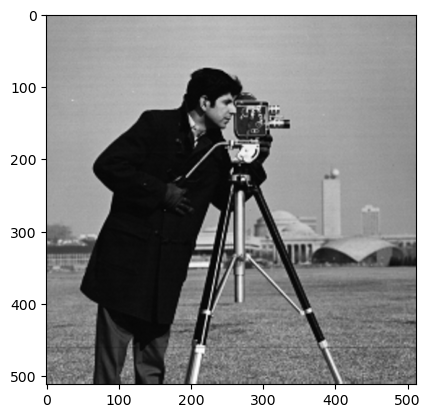

(512, 512)
<class 'numpy.ndarray'>
[[156 157 160 ... 152 152 152]
 [156 157 159 ... 152 152 152]
 [158 157 156 ... 152 152 152]
 ...
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]]


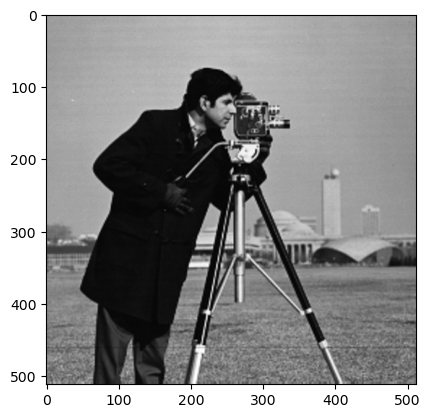

In [248]:
import cv2 as cv

pic_address = 'test_pics\\standard cases\\cameraman.tif'

pic = cv.imread (pic_address)

pic = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
plt.imshow (pic)
plt.show ()

pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
print (pic.shape)
print (type (pic))
print (pic [:,:])


plt.imshow (pic [:, :], cmap= 'gray')
plt.show ()

pic shape:  (512, 512)


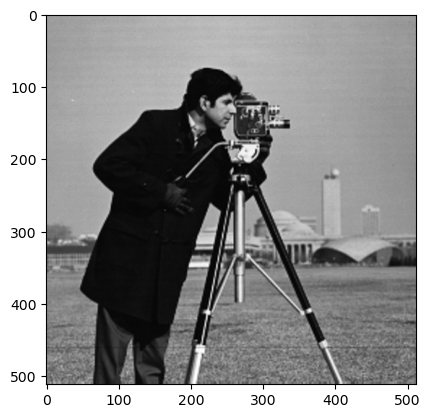

In [249]:
pic = cv.imread (pic_address)
pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
pic = divideArrayIntoBatches (pic, 1) [0]

print ('pic shape: ',pic.shape)

plt.imshow (pic, cmap = 'gray')
plt.show ()

pic_recons size: (512, 512)


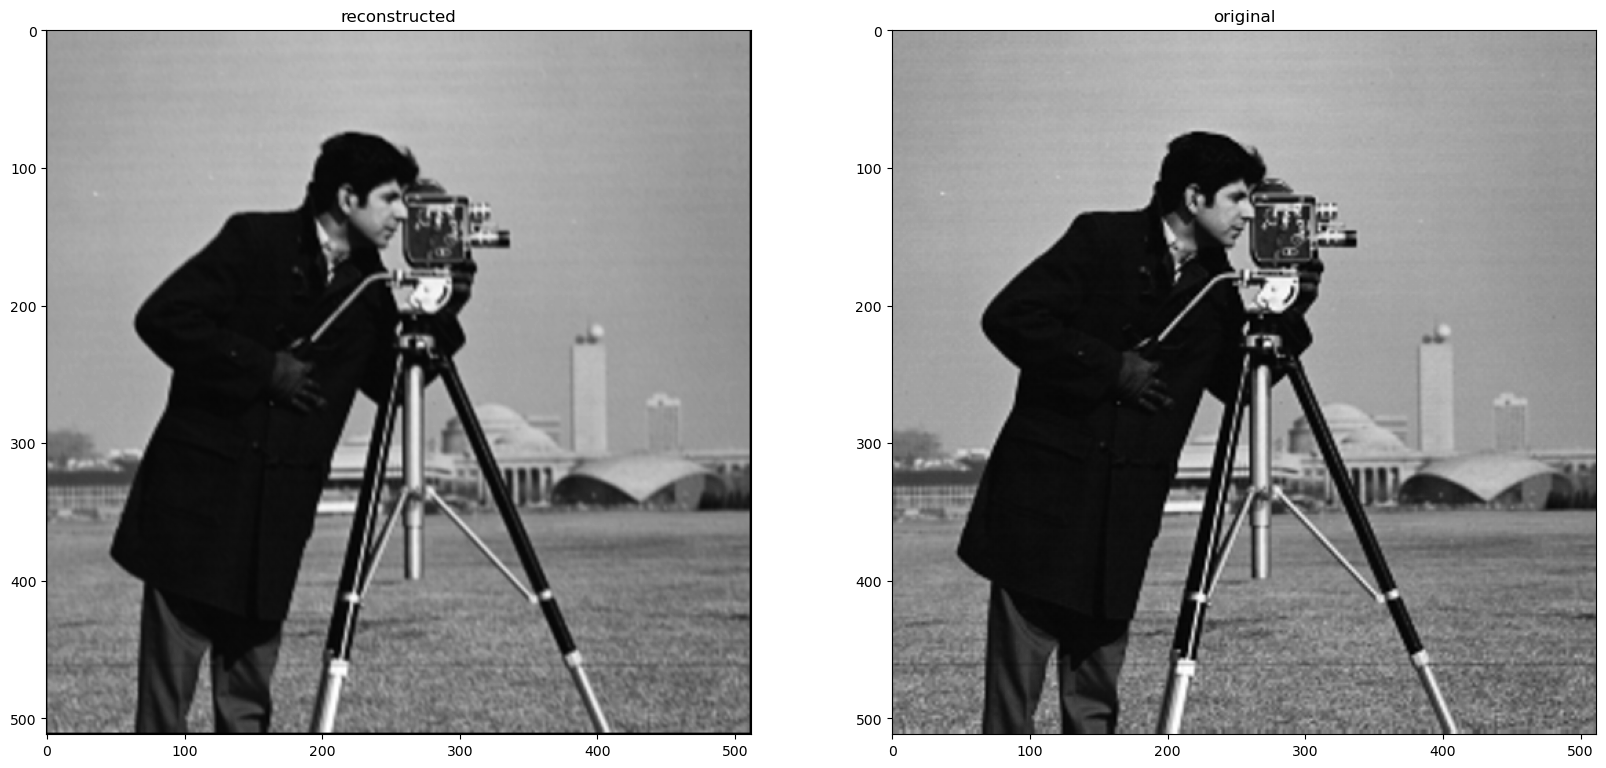

MSE Score:252.02684777741683


In [250]:
# Compression:

def calculateACoefs (pic):
    """
        Calculates the aCoefs using the given 2D numpy array (pic)

        Args:
            pic: a 2D numpy array representing the picture.

        Returns:
            aCoefs: a 1D numpy arrau containing the calculated aCoefs.
    """
    from numpy import mean

    R22 = R33 = R44 = R55 = mean (mean (pic * pic))
    R12 = R34 = R45 = mean ( mean (pic[: , 1:-1] * pic[: , 2:]))
    R13 = mean (mean (pic[1:-1, 1:-1] * pic[2:, 2:]))
    R14 = R23 = mean (mean (pic[1:-1 , :] * pic[2:, :]))
    R15 = R24 = mean (mean (pic[2:, 1:-1] * pic[1:-1, 2:]))
    R25 = mean (mean (pic[1:-1, 3:] * pic[2:, 1:-2]))
    R35 = mean (mean (pic[:, 3:] * pic[:, 1:-2]))

    Phi = np.array ([[R22, R23, R24, R25],
                    [R23, R22, R34, R35],
                    [R24, R34, R22, R45],
                    [R25, R35, R45, R22]])

    R = np.array ([R12, R13, R14, R15])

    # print ('Phi:\n', Phi)
    # print ('R:\n', R)

    # aCoefs = np.linalg.inv(Phi) @ R
    aCoefs = np.linalg.solve (Phi, R)

    # print ('\nPhi:\n{}\n'.format (Phi))
    # print ('R:\n{}\n'.format (R))
    # print ('aCoefs:\n{}\n'.format (aCoefs))

    return aCoefs

# Reconstruction:

def reconstructPicfromACoefs (aCoefs, pic):
    """
    Reconstructs the image using the given 2D numpy array (pic) and aCoefs.

    Args:
        aCoefs: a 1D numpy array containing aCoefs.
        pic: a 2D numpy array representing the picture. 

    Returns:
        pic_recons_frompic: a 2D numpy array representing the recontructed image using the original image.

    """

    pic_recons_fromzero = np.zeros (pic.shape, dtype='double')
    pic_recons_fromzero[:,0] = pic[:,0]
    pic_recons_fromzero[0,:] = pic[0,:]

    print ('pic_recons size: {}'.format (pic_recons_fromzero.shape))


    for i in range (1 , pic.shape[0]-1):
        for j in range (1, pic.shape[1]-1):
            pic_recons_fromzero [i, j] = aCoefs[0]*pic_recons_fromzero[i-1,j] + aCoefs[1]*pic_recons_fromzero[i-1,j+1] + aCoefs[2]*pic_recons_fromzero[i,j+1] + aCoefs[3]*pic_recons_fromzero[i+1,j+1]

    # plt.imshow (pic_recons_fromzero)

    pic_recons_frompic = np.zeros (pic.shape, dtype='double')

    # for i in range (1 , pic.shape[0]-1):
    #     for j in range (1, pic.shape[1]-1):
    #         pic_recons_frompic [i, j] = aCoefs[0]*pic[i-1,j] + aCoefs[1]*pic[i-1,j+1] + aCoefs[2]*pic[i,j+1] + aCoefs[3]*pic[i+1,j+1]

    # more efficient alternative:
    pic_recons_frompic[1:-1, 1:-1] = aCoefs[0] * pic[:-2, 1:-1] + aCoefs[1] * pic[:-2, 2:] + aCoefs[2] * pic[1:-1, 2:] + aCoefs[3] * pic[2:, 2:]

    return pic_recons_frompic

# MSE Score: 

def mse(img1, img2): # MSE Score
   h, w = img1.shape
   diff = abs (img1 - img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse

pic_recons_frompic = reconstructPicfromACoefs (calculateACoefs (pic), pic)

plt.figure (figsize=(20,10))
plt.subplot (1,2,1)
plt.imshow (pic_recons_frompic, cmap='gray')
plt.title (label='reconstructed')
plt.subplot (1,2,2)
plt.imshow (pic, cmap='gray')
plt.title (label='original')
plt.show()


mse_score = mse(pic, pic_recons_frompic)
print ('MSE Score:{}'.format (mse_score))


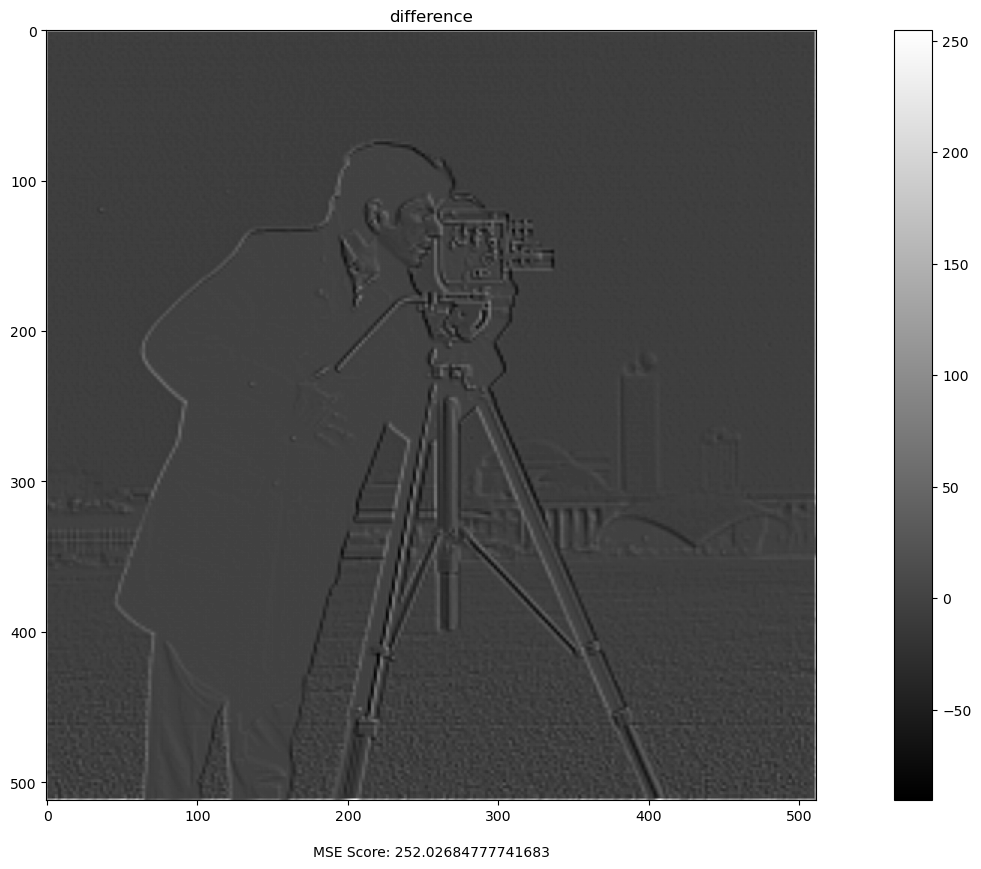

[[156.         157.         160.         ... 152.         152.
  152.        ]
 [156.          -6.51657966  -5.01138287 ...  -5.41835134  -5.41835134
  152.        ]
 [158.          -5.0679487   -6.48632157 ...  -5.41835134  -5.41835134
  152.        ]
 ...
 [121.          -7.42571271  -6.22706411 ...   0.98122892  -1.82896244
  111.        ]
 [121.          -6.52692242  -4.49152808 ...   1.39960178  -2.5998928
  111.        ]
 [121.         123.         126.         ... 121.         113.
  111.        ]]


In [251]:
# plt.imshow (cv.absdiff (pic, pic_recons_frompic), cmap= 'YlOrBr')

def createDiffMatrix (pic, pic_recons):
    return pic - pic_recons

diff = createDiffMatrix(pic, pic_recons_frompic)

plt.figure (figsize=(20,10))
# plt.imshow (diff, cmap= 'YlOrBr')
plt.imshow (diff, cmap= 'gray')
plt.title (label='difference')
plt.xlabel ('\nMSE Score: {}'.format (mse_score))
plt.colorbar ()
plt.show()
print (diff)

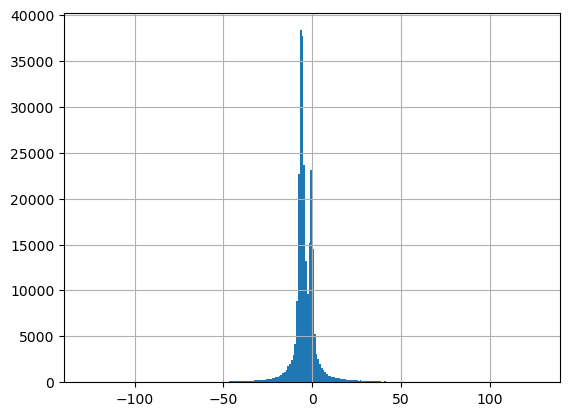

In [252]:
plt.hist (diff.ravel(), 256, [-127, 127])
plt.grid ()
plt.show ()

pic_recons size: (512, 512)


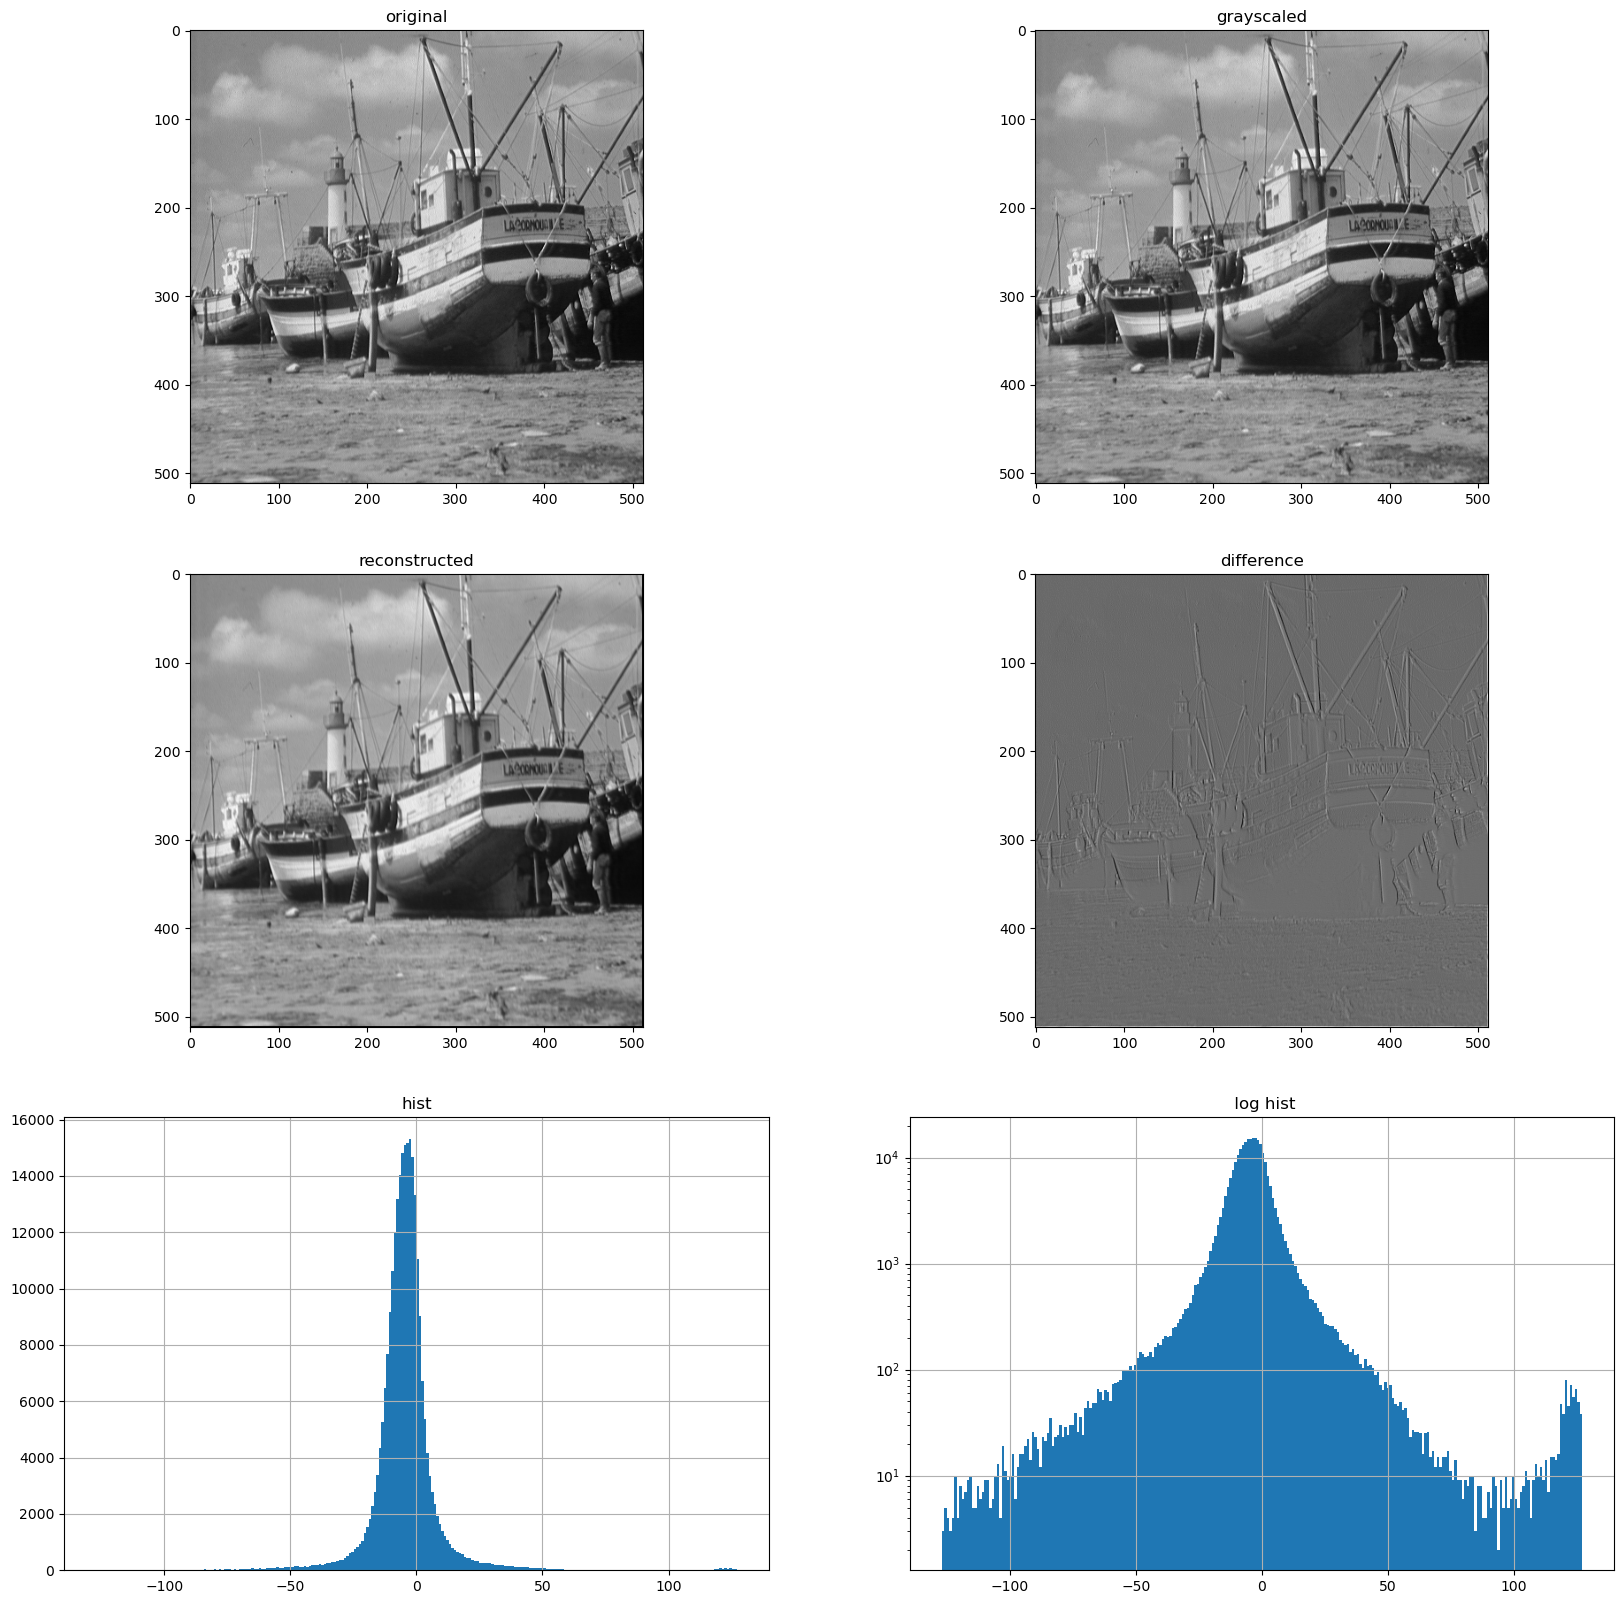

In [275]:
def report_2 (pic_address):

    pic = cv.imread (pic_address)


    plt.figure (figsize= (20, 20))

    plt.subplot (3,2,1)
    pic = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
    plt.imshow (pic)
    plt.title (label='original')

    plt.subplot (3,2,2)
    pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
    plt.imshow (pic, cmap= 'gray')
    plt.title (label='grayscaled')

    plt.subplot (3,2,3)
    pic_recons_frompic = reconstructPicfromACoefs (calculateACoefs (pic), pic)
    plt.imshow (pic_recons_frompic, cmap='gray')
    plt.title (label='reconstructed')

    plt.subplot (3,2,4)
    diff = createDiffMatrix(pic, pic_recons_frompic)
    plt.imshow (diff, cmap= 'gray')
    plt.title (label='difference')

    plt.subplot (3,2,5)
    plt.hist (diff.ravel(), 256, [-127, 127], log=False)
    plt.title (label='hist')
    plt.grid ()

    plt.subplot (3,2,6)
    plt.hist (diff.ravel(), 256, [-127, 127], log=True)
    plt.title (label=' log hist')
    plt.grid ()

    plt.show ()

report_2 ('test_pics\\standard cases\\boat.png')